# MLP for NLP Classification
Reference Docs:
- https://colab.research.google.com/drive/1WUy4G2SsoLelrZDkO2I0v9tHx9x27NJK?usp=sharing

### Imports and Settings

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import torch
%matplotlib inline

import json
import torch

with open ('../settings.json') as f:
    settings = json.load(f)

DATA_DIR = os.path.join(settings['data_path'], 'classifier')
os.makedirs(DATA_DIR, exist_ok=True)
CHECKPOINT_DIR = os.path.join(DATA_DIR, "model_data")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_PREFIX = os.path.join(CHECKPOINT_DIR, "mlp4mal-test")

RANDOM_SEED = 4444
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCABULARY_SIZE = 20000
DROPOUT = 0.25
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 128
BATCH_SIZE = 64
NUM_EPOCHS = 15
NUM_CLASSES = 4
MAX_LENGTH = 20480 * 2
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



### Set up CUDA debug environment

In [2]:
# Enable synchronous CUDA execution for better error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Enable device-side assertions in CUDA kernels
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Confirm the variables are set
print("CUDA_LAUNCH_BLOCKING =", os.getenv('CUDA_LAUNCH_BLOCKING'))
print("TORCH_USE_CUDA_DSA =", os.getenv('TORCH_USE_CUDA_DSA'))

CUDA_LAUNCH_BLOCKING = 1
TORCH_USE_CUDA_DSA = 1


### Load Data (already cleaned and selected)

In [3]:
from datasets import load_dataset

REPORT_DIR = os.path.join(DATA_DIR, "report_data")
os.makedirs(REPORT_DIR, exist_ok=True)

# get all files in the report directory
file_paths = [os.path.join(REPORT_DIR, f) for f in os.listdir(REPORT_DIR) if os.path.isfile(os.path.join(REPORT_DIR, f))]
print(file_paths)

dataset = load_dataset('json', data_files=file_paths)['train']
print(dataset)
# # get 1000 random samples
# dataset = dataset.shuffle(seed=RANDOM_SEED)
# dataset = dataset.select(list(range(1000)))
# print(dataset)

['/media/mike/Data/gimc/classifier/report_data/json_0.json', '/media/mike/Data/gimc/classifier/report_data/json_1.json', '/media/mike/Data/gimc/classifier/report_data/json_10.json', '/media/mike/Data/gimc/classifier/report_data/json_11.json', '/media/mike/Data/gimc/classifier/report_data/json_12.json', '/media/mike/Data/gimc/classifier/report_data/json_13.json', '/media/mike/Data/gimc/classifier/report_data/json_14.json', '/media/mike/Data/gimc/classifier/report_data/json_15.json', '/media/mike/Data/gimc/classifier/report_data/json_2.json', '/media/mike/Data/gimc/classifier/report_data/json_3.json', '/media/mike/Data/gimc/classifier/report_data/json_4.json', '/media/mike/Data/gimc/classifier/report_data/json_5.json', '/media/mike/Data/gimc/classifier/report_data/json_6.json', '/media/mike/Data/gimc/classifier/report_data/json_7.json', '/media/mike/Data/gimc/classifier/report_data/json_8.json', '/media/mike/Data/gimc/classifier/report_data/json_9.json']
Dataset({
    features: ['text', 

### Split Data for k-fold cross validation

In [4]:
# reserve 10% as test, use 90% for training+validation
train_val_split = dataset.train_test_split(test_size=0.1, seed=42, shuffle=True)
train_val_dataset = train_val_split['train']   # 90% of data for K-fold CV
test_dataset      = train_val_split['test']    # 10% hold-out test set

print(f"Train+Val pool: {len(train_val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Train+Val pool: 14400 samples
Test set: 1600 samples


### Load Tokenizer

In [5]:
tokenizer_path = os.path.join(DATA_DIR, 'model_data', 'mal-reformer')
print(f"Tokenizer path: {tokenizer_path}")

import torch
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
tokenizer.pad_token = "[PAD]"
tokenizer.cls_token = "[CLS]"
tokenizer.sep_token = "[SEP]"

Tokenizer path: /media/mike/Data/gimc/classifier/model_data/mal-reformer


### Tokenizer Function

In [6]:
def tokenize_function(example):
    return tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

In [7]:
# Tokenize the train+val combined data and the test set
tokenized_train_val = train_val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/14400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

### Implement Stratified K-Fold Cross-Validation

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

K = 10  # for example, 5-fold cross-validation
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# Prepare arrays of all inputs and labels from the tokenized training pool
all_inputs = np.array(tokenized_train_val["input_ids"])
all_labels = np.array(tokenized_train_val["label"])

In [9]:
%load_ext autoreload
%autoreload 2
from utils.train import train_model
from torch.utils.data import DataLoader, TensorDataset
from utils.plot import plot_accuracy, plot_training_loss
from torch import optim
from models.mlp_nlp import MLP_NLP

fold_accuracies = []  # to collect validation accuracies from each fold

for fold, (train_idx, val_idx) in enumerate(skf.split(all_inputs, all_labels), start=1):
    print(f"\nFold {fold}:")
    # Split the data into training and validation sets for this fold
    X_train_fold = all_inputs[train_idx]
    y_train_fold = all_labels[train_idx]
    X_val_fold   = all_inputs[val_idx]
    y_val_fold   = all_labels[val_idx]
    
    # Create TensorDatasets for this fold
    train_data = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
    val_data   = TensorDataset(torch.tensor(X_val_fold),   torch.tensor(y_val_fold))
    
    # DataLoaders for this fold
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize a fresh model and optimizer for each fold
    model = MLP_NLP(vocab_size=VOCABULARY_SIZE, 
                    embed_dim=EMBEDDING_DIM, 
                    num_class=NUM_CLASSES,
                    hidden_size1=513, hidden_size2=256, hidden_size3=128, 
                    dropout=DROPOUT).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model on this fold's data
    _, train_acc_list, val_acc_list = train_model(
        model=model,
        num_epochs=NUM_EPOCHS,
        train_loader=train_loader,
        valid_loader=val_loader,
        test_loader=None,             # No test evaluation during CV folds
        optimizer=optimizer,
        device=DEVICE,
        scheduler=None,               # (Optional: use a scheduler if desired)
        checkpoint_prefix=None,       # Disable checkpointing for CV
        logging_interval=100
    )
    # Record this fold's final validation accuracy
    fold_final_acc = val_acc_list[-1]
    fold_accuracies.append(fold_final_acc)
    print(f"Fold {fold} final validation accuracy: {fold_final_acc:.2f}%")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Fold 1:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 92.96% | Validation: 93.47% | Elapsed: 0.12 min


Epoch: 002/015 | Train: 92.69% | Validation: 92.99% | Elapsed: 0.23 min


Epoch: 003/015 | Train: 93.04% | Validation: 93.33% | Elapsed: 0.35 min


Epoch: 004/015 | Train: 93.10% | Validation: 93.40% | Elapsed: 0.47 min


Epoch: 005/015 | Train: 93.24% | Validation: 93.61% | Elapsed: 0.59 min


Epoch: 006/015 | Train: 93.29% | Validation: 93.68% | Elapsed: 0.70 min


Epoch: 007/015 | Train: 93.35% | Validation: 93.82% | Elapsed: 0.82 min


Epoch: 008/015 | Train: 93.39% | Validation: 93.89% | Elapsed: 0.93 min


Epoch: 009/015 | Train: 93.45% | Validation: 93.89% | Elapsed: 1.05 min


Epoch: 010/015 | Train: 93.51% | Validation: 94.03% | Elapsed: 1.17 min


Epoch: 011/015 | Train: 93.57% | Validation: 94.17% | Elapsed: 1.29 min


Epoch: 012/015 | Train: 93.46% | Validation: 94.10% | Elapsed: 1.42 min


Epoch: 013/015 | Train: 93.48% | Validation: 93.96% | Elapsed: 1.55 min


Epoch: 014/015 | Train: 94.33% | Validation: 94.51% | Elapsed: 1.69 min


Epoch: 015/015 | Train: 94.29% | Validation: 94.38% | Elapsed: 1.82 min
Total Training Time: 1.82 min
Fold 1 final validation accuracy: 94.38%

Fold 2:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 92.43% | Validation: 93.06% | Elapsed: 0.13 min


Epoch: 002/015 | Train: 92.97% | Validation: 93.47% | Elapsed: 0.26 min


Epoch: 003/015 | Train: 93.21% | Validation: 93.82% | Elapsed: 0.39 min


Epoch: 004/015 | Train: 93.28% | Validation: 94.10% | Elapsed: 0.53 min


Epoch: 005/015 | Train: 93.32% | Validation: 93.96% | Elapsed: 0.66 min


Epoch: 006/015 | Train: 93.35% | Validation: 94.10% | Elapsed: 0.79 min


Epoch: 007/015 | Train: 93.89% | Validation: 94.38% | Elapsed: 0.92 min


Epoch: 008/015 | Train: 93.87% | Validation: 94.51% | Elapsed: 1.05 min


Epoch: 009/015 | Train: 93.45% | Validation: 94.24% | Elapsed: 1.19 min


Epoch: 010/015 | Train: 94.25% | Validation: 94.72% | Elapsed: 1.32 min


Epoch: 011/015 | Train: 93.94% | Validation: 94.58% | Elapsed: 1.45 min


Epoch: 012/015 | Train: 93.83% | Validation: 94.31% | Elapsed: 1.58 min


Epoch: 013/015 | Train: 93.74% | Validation: 94.31% | Elapsed: 1.71 min


Epoch: 014/015 | Train: 93.64% | Validation: 94.31% | Elapsed: 1.85 min


Epoch: 015/015 | Train: 93.67% | Validation: 94.38% | Elapsed: 1.98 min
Total Training Time: 1.98 min
Fold 2 final validation accuracy: 94.38%

Fold 3:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 93.03% | Validation: 93.61% | Elapsed: 0.13 min


Epoch: 002/015 | Train: 93.29% | Validation: 93.68% | Elapsed: 0.26 min


Epoch: 003/015 | Train: 93.35% | Validation: 93.96% | Elapsed: 0.39 min


Epoch: 004/015 | Train: 93.34% | Validation: 93.68% | Elapsed: 0.53 min


Epoch: 005/015 | Train: 93.53% | Validation: 94.03% | Elapsed: 0.66 min


Epoch: 006/015 | Train: 93.33% | Validation: 93.89% | Elapsed: 0.79 min


Epoch: 007/015 | Train: 93.63% | Validation: 93.89% | Elapsed: 0.92 min


Epoch: 008/015 | Train: 94.12% | Validation: 94.24% | Elapsed: 1.05 min


Epoch: 009/015 | Train: 93.50% | Validation: 93.96% | Elapsed: 1.19 min


Epoch: 010/015 | Train: 93.53% | Validation: 93.82% | Elapsed: 1.32 min


Epoch: 011/015 | Train: 93.83% | Validation: 94.10% | Elapsed: 1.45 min


Epoch: 012/015 | Train: 93.73% | Validation: 94.10% | Elapsed: 1.58 min


Epoch: 013/015 | Train: 94.43% | Validation: 94.93% | Elapsed: 1.71 min


Epoch: 014/015 | Train: 94.48% | Validation: 94.72% | Elapsed: 1.84 min


Epoch: 015/015 | Train: 94.44% | Validation: 94.65% | Elapsed: 1.98 min
Total Training Time: 1.98 min
Fold 3 final validation accuracy: 94.65%

Fold 4:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 93.07% | Validation: 92.92% | Elapsed: 0.13 min


Epoch: 002/015 | Train: 93.33% | Validation: 93.06% | Elapsed: 0.26 min


Epoch: 003/015 | Train: 93.49% | Validation: 93.26% | Elapsed: 0.39 min


Epoch: 004/015 | Train: 93.57% | Validation: 93.19% | Elapsed: 0.53 min


Epoch: 005/015 | Train: 93.70% | Validation: 93.12% | Elapsed: 0.66 min


Epoch: 006/015 | Train: 93.62% | Validation: 93.19% | Elapsed: 0.79 min


Epoch: 007/015 | Train: 93.78% | Validation: 93.33% | Elapsed: 0.92 min


Epoch: 008/015 | Train: 93.53% | Validation: 93.12% | Elapsed: 1.05 min


Epoch: 009/015 | Train: 93.70% | Validation: 93.26% | Elapsed: 1.19 min


Epoch: 010/015 | Train: 93.63% | Validation: 93.12% | Elapsed: 1.32 min


Epoch: 011/015 | Train: 94.44% | Validation: 94.17% | Elapsed: 1.45 min


Epoch: 012/015 | Train: 94.01% | Validation: 93.54% | Elapsed: 1.58 min


Epoch: 013/015 | Train: 94.09% | Validation: 93.54% | Elapsed: 1.71 min


Epoch: 014/015 | Train: 93.96% | Validation: 93.54% | Elapsed: 1.85 min


Epoch: 015/015 | Train: 94.48% | Validation: 94.31% | Elapsed: 1.98 min
Total Training Time: 1.98 min
Fold 4 final validation accuracy: 94.31%

Fold 5:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 92.30% | Validation: 91.60% | Elapsed: 0.13 min


Epoch: 002/015 | Train: 93.35% | Validation: 93.19% | Elapsed: 0.26 min


Epoch: 003/015 | Train: 93.37% | Validation: 93.26% | Elapsed: 0.40 min


Epoch: 004/015 | Train: 93.30% | Validation: 92.92% | Elapsed: 0.53 min


Epoch: 005/015 | Train: 93.27% | Validation: 93.19% | Elapsed: 0.66 min


Epoch: 006/015 | Train: 93.40% | Validation: 93.06% | Elapsed: 0.79 min


Epoch: 007/015 | Train: 93.44% | Validation: 93.12% | Elapsed: 0.92 min


Epoch: 008/015 | Train: 94.12% | Validation: 93.68% | Elapsed: 1.05 min


Epoch: 009/015 | Train: 93.67% | Validation: 93.47% | Elapsed: 1.19 min


Epoch: 010/015 | Train: 94.35% | Validation: 94.31% | Elapsed: 1.32 min


Epoch: 011/015 | Train: 93.70% | Validation: 93.61% | Elapsed: 1.45 min


Epoch: 012/015 | Train: 94.44% | Validation: 94.31% | Elapsed: 1.58 min


Epoch: 013/015 | Train: 94.14% | Validation: 93.96% | Elapsed: 1.71 min


Epoch: 014/015 | Train: 94.58% | Validation: 94.03% | Elapsed: 1.85 min


Epoch: 015/015 | Train: 94.57% | Validation: 94.44% | Elapsed: 1.98 min
Total Training Time: 1.98 min
Fold 5 final validation accuracy: 94.44%

Fold 6:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 92.88% | Validation: 93.26% | Elapsed: 0.13 min


Epoch: 002/015 | Train: 93.16% | Validation: 93.54% | Elapsed: 0.26 min


Epoch: 003/015 | Train: 93.19% | Validation: 93.75% | Elapsed: 0.40 min


Epoch: 004/015 | Train: 93.29% | Validation: 93.75% | Elapsed: 0.53 min


Epoch: 005/015 | Train: 93.33% | Validation: 93.68% | Elapsed: 0.66 min


Epoch: 006/015 | Train: 93.51% | Validation: 94.10% | Elapsed: 0.79 min


Epoch: 007/015 | Train: 93.53% | Validation: 93.96% | Elapsed: 0.92 min


Epoch: 008/015 | Train: 93.63% | Validation: 94.10% | Elapsed: 1.05 min


Epoch: 009/015 | Train: 93.93% | Validation: 94.17% | Elapsed: 1.19 min


Epoch: 010/015 | Train: 93.72% | Validation: 93.96% | Elapsed: 1.32 min


Epoch: 011/015 | Train: 94.31% | Validation: 94.86% | Elapsed: 1.45 min


Epoch: 012/015 | Train: 93.58% | Validation: 93.82% | Elapsed: 1.58 min


Epoch: 013/015 | Train: 93.94% | Validation: 94.24% | Elapsed: 1.71 min


Epoch: 014/015 | Train: 94.45% | Validation: 95.07% | Elapsed: 1.84 min


Epoch: 015/015 | Train: 94.54% | Validation: 95.14% | Elapsed: 1.98 min
Total Training Time: 1.98 min
Fold 6 final validation accuracy: 95.14%

Fold 7:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 93.02% | Validation: 92.22% | Elapsed: 0.13 min


Epoch: 002/015 | Train: 92.60% | Validation: 90.56% | Elapsed: 0.26 min


Epoch: 003/015 | Train: 93.31% | Validation: 92.57% | Elapsed: 0.40 min


Epoch: 004/015 | Train: 93.39% | Validation: 92.43% | Elapsed: 0.53 min


Epoch: 005/015 | Train: 93.39% | Validation: 92.50% | Elapsed: 0.66 min


Epoch: 006/015 | Train: 94.09% | Validation: 93.19% | Elapsed: 0.79 min


Epoch: 007/015 | Train: 93.50% | Validation: 92.15% | Elapsed: 0.92 min


Epoch: 008/015 | Train: 93.58% | Validation: 92.71% | Elapsed: 1.06 min


Epoch: 009/015 | Train: 94.15% | Validation: 93.33% | Elapsed: 1.19 min


Epoch: 010/015 | Train: 94.38% | Validation: 93.68% | Elapsed: 1.32 min


Epoch: 011/015 | Train: 93.90% | Validation: 92.92% | Elapsed: 1.45 min


Epoch: 012/015 | Train: 94.30% | Validation: 93.54% | Elapsed: 1.58 min


Epoch: 013/015 | Train: 94.38% | Validation: 93.68% | Elapsed: 1.71 min


Epoch: 014/015 | Train: 93.87% | Validation: 92.99% | Elapsed: 1.85 min


Epoch: 015/015 | Train: 94.31% | Validation: 93.82% | Elapsed: 1.98 min
Total Training Time: 1.98 min
Fold 7 final validation accuracy: 93.82%

Fold 8:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 92.89% | Validation: 92.78% | Elapsed: 0.13 min


Epoch: 002/015 | Train: 92.95% | Validation: 92.71% | Elapsed: 0.26 min


Epoch: 003/015 | Train: 93.31% | Validation: 92.85% | Elapsed: 0.39 min


Epoch: 004/015 | Train: 93.34% | Validation: 92.92% | Elapsed: 0.53 min


Epoch: 005/015 | Train: 93.45% | Validation: 92.92% | Elapsed: 0.66 min


Epoch: 006/015 | Train: 93.45% | Validation: 92.92% | Elapsed: 0.79 min


Epoch: 007/015 | Train: 93.56% | Validation: 92.92% | Elapsed: 0.92 min


Epoch: 008/015 | Train: 93.50% | Validation: 92.92% | Elapsed: 1.05 min


Epoch: 009/015 | Train: 93.66% | Validation: 92.92% | Elapsed: 1.18 min


Epoch: 010/015 | Train: 93.56% | Validation: 92.92% | Elapsed: 1.31 min


Epoch: 011/015 | Train: 93.63% | Validation: 93.06% | Elapsed: 1.45 min


Epoch: 012/015 | Train: 93.67% | Validation: 93.12% | Elapsed: 1.58 min


Epoch: 013/015 | Train: 93.75% | Validation: 93.19% | Elapsed: 1.71 min


Epoch: 014/015 | Train: 94.34% | Validation: 93.68% | Elapsed: 1.84 min


Epoch: 015/015 | Train: 93.73% | Validation: 93.26% | Elapsed: 1.97 min
Total Training Time: 1.97 min
Fold 8 final validation accuracy: 93.26%

Fold 9:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 93.14% | Validation: 92.71% | Elapsed: 0.13 min


Epoch: 002/015 | Train: 93.36% | Validation: 93.06% | Elapsed: 0.26 min


Epoch: 003/015 | Train: 93.36% | Validation: 93.06% | Elapsed: 0.40 min


Epoch: 004/015 | Train: 93.31% | Validation: 92.78% | Elapsed: 0.53 min


Epoch: 005/015 | Train: 93.50% | Validation: 93.19% | Elapsed: 0.66 min


Epoch: 006/015 | Train: 93.89% | Validation: 93.68% | Elapsed: 0.79 min


Epoch: 007/015 | Train: 93.61% | Validation: 93.26% | Elapsed: 0.93 min


Epoch: 008/015 | Train: 93.50% | Validation: 93.19% | Elapsed: 1.06 min


Epoch: 009/015 | Train: 94.14% | Validation: 93.82% | Elapsed: 1.19 min


Epoch: 010/015 | Train: 93.53% | Validation: 93.12% | Elapsed: 1.32 min


Epoch: 011/015 | Train: 94.31% | Validation: 93.96% | Elapsed: 1.45 min


Epoch: 012/015 | Train: 93.76% | Validation: 93.47% | Elapsed: 1.58 min


Epoch: 013/015 | Train: 93.73% | Validation: 93.40% | Elapsed: 1.71 min


Epoch: 014/015 | Train: 93.68% | Validation: 93.47% | Elapsed: 1.85 min


Epoch: 015/015 | Train: 94.35% | Validation: 93.82% | Elapsed: 1.98 min
Total Training Time: 1.98 min
Fold 9 final validation accuracy: 93.82%

Fold 10:
No checkpoint found at None. Start training from scratch.


Epoch: 001/015 | Train: 92.98% | Validation: 92.29% | Elapsed: 0.13 min


Epoch: 002/015 | Train: 93.15% | Validation: 92.64% | Elapsed: 0.26 min


Epoch: 003/015 | Train: 93.26% | Validation: 92.57% | Elapsed: 0.40 min


Epoch: 004/015 | Train: 93.23% | Validation: 92.78% | Elapsed: 0.53 min


Epoch: 005/015 | Train: 93.27% | Validation: 92.92% | Elapsed: 0.66 min


Epoch: 006/015 | Train: 93.44% | Validation: 92.99% | Elapsed: 0.79 min


Epoch: 007/015 | Train: 93.46% | Validation: 93.12% | Elapsed: 0.92 min


Epoch: 008/015 | Train: 94.12% | Validation: 93.96% | Elapsed: 1.05 min


Epoch: 009/015 | Train: 93.75% | Validation: 93.47% | Elapsed: 1.19 min


Epoch: 010/015 | Train: 94.36% | Validation: 94.10% | Elapsed: 1.32 min


Epoch: 011/015 | Train: 94.54% | Validation: 94.17% | Elapsed: 1.45 min


Epoch: 012/015 | Train: 93.56% | Validation: 93.26% | Elapsed: 1.58 min


Epoch: 013/015 | Train: 93.97% | Validation: 93.54% | Elapsed: 1.71 min


Epoch: 014/015 | Train: 94.01% | Validation: 93.75% | Elapsed: 1.85 min


Epoch: 015/015 | Train: 94.58% | Validation: 93.89% | Elapsed: 1.98 min
Total Training Time: 1.98 min
Fold 10 final validation accuracy: 93.89%


In [10]:
# Calculate mean and std of validation accuracies across folds
mean_val_accuracy = np.mean(fold_accuracies)
std_val_accuracy  = np.std(fold_accuracies)
print(f"\n{K}-Fold CV Mean Validation Accuracy: {mean_val_accuracy:.2f}%")
print(f"{K}-Fold CV Std. Dev.: {std_val_accuracy:.2f}%")



10-Fold CV Mean Validation Accuracy: 94.21%
10-Fold CV Std. Dev.: 0.50%


### Final Modal Training and Evaluation

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import torch


# Prepare arrays of all inputs and labels from the tokenized training and test pools
train_inputs = np.array(tokenized_train_val["input_ids"])
train_labels = np.array(tokenized_train_val["label"])

test_inputs = np.array(tokenized_test["input_ids"])
test_labels = np.array(tokenized_test["label"])

# Convert lists to torch.Tensor
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
test_inputs  = torch.tensor(test_inputs)
test_labels  = torch.tensor(test_labels)

# Create TensorDataset objects
train_data = TensorDataset(train_inputs, train_labels)
test_data  = TensorDataset(test_inputs, test_labels)

# Create DataLoaders
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=BATCH_SIZE)

print(f"Full training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Full training set size: 14400
Test set size: 1600


### Train Loop

No checkpoint found at /media/mike/Data/gimc/classifier/model_data/mlp4mal-test_checkpoint.pth. Start training from scratch.


Epoch: 001/015 | Train: 93.12% | Validation: 93.62% | Elapsed: 0.15 min


Epoch: 002/015 | Train: 93.07% | Validation: 93.12% | Elapsed: 0.29 min


Epoch: 003/015 | Train: 93.08% | Validation: 93.12% | Elapsed: 0.43 min


Epoch: 004/015 | Train: 93.25% | Validation: 93.31% | Elapsed: 0.58 min


Epoch: 005/015 | Train: 93.47% | Validation: 93.56% | Elapsed: 0.72 min


Epoch: 006/015 | Train: 93.59% | Validation: 93.81% | Elapsed: 0.86 min


Epoch: 007/015 | Train: 93.40% | Validation: 93.62% | Elapsed: 1.00 min


Epoch: 008/015 | Train: 93.53% | Validation: 93.75% | Elapsed: 1.15 min


Epoch: 009/015 | Train: 93.67% | Validation: 94.06% | Elapsed: 1.29 min


Epoch: 010/015 | Train: 93.52% | Validation: 93.69% | Elapsed: 1.44 min


Epoch: 011/015 | Train: 94.17% | Validation: 94.44% | Elapsed: 1.58 min


Epoch: 012/015 | Train: 94.45% | Validation: 94.44% | Elapsed: 1.73 min


Epoch: 013/015 | Train: 94.51% | Validation: 94.38% | Elapsed: 1.88 min


Epoch: 014/015 | Train: 93.87% | Validation: 94.06% | Elapsed: 2.02 min


Epoch: 015/015 | Train: 94.61% | Validation: 94.25% | Elapsed: 2.17 min
Total Training Time: 2.18 min


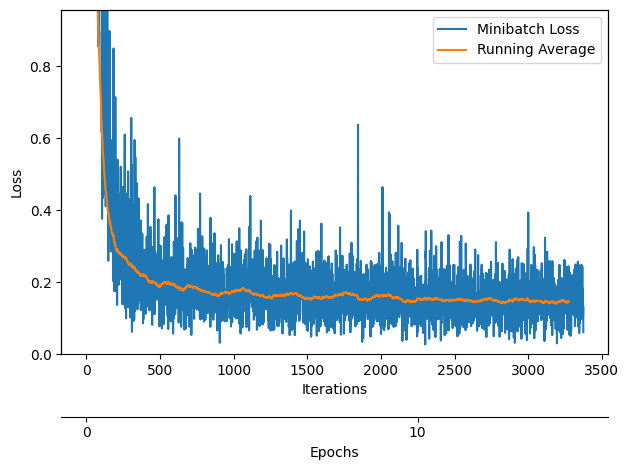

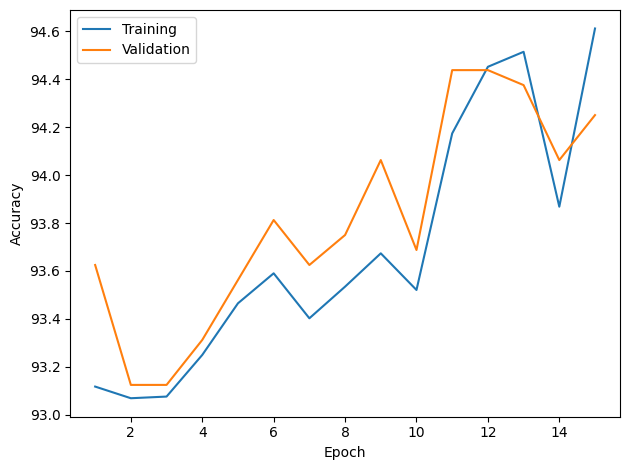

In [12]:
from utils.train import train_model
from utils.plot import plot_accuracy, plot_training_loss
from torch import optim
from models.mlp_nlp import MLP_NLP

model = MLP_NLP(vocab_size=VOCABULARY_SIZE,
                embed_dim=EMBEDDING_DIM,
                num_class=NUM_CLASSES,
                hidden_size1=513,
                hidden_size2=256,
                hidden_size3=128,
                dropout=DROPOUT)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

model = model.to(DEVICE)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_dataloader,
    valid_loader=test_dataloader,
    test_loader=None,
    optimizer=optimizer,
    checkpoint_prefix=CHECKPOINT_PREFIX,
    device=DEVICE,
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataloader),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)